In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randint
import pickle
import os
from zipfile import ZipFile
%matplotlib inline

In [2]:
path = '/tmp/'
traffic_signs_file = 'traffic-signs-data.zip'

## Load Data

In [3]:
!wget --no-check-certificate \
    https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip \
    -O /tmp/traffic-signs-data.zip

with ZipFile(path+traffic_signs_file, 'r') as zipObj:
   zipObj.extractall(path)
   print('Finish extracting')

--2020-09-22 14:12:35--  https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/traffic-signs-data.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.120
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123524425 (118M) [application/zip]
Saving to: ‘/tmp/traffic-signs-data.zip’

/tmp/traffic-signs- 100%[===================>] 117,80M  8,63MB/s    in 39s     

2020-09-22 14:13:15 (3,01 MB/s) - ‘/tmp/traffic-signs-data.zip’ saved [123524425/123524425]

Finish extracting


In [3]:
train = pickle.load(open(path+"train.p", 'rb'))
valid=pickle.load(open(path+"valid.p", 'rb'))
test = pickle.load(open(path+"test.p", 'rb'))

In [4]:
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

## Data description

In [5]:
# Verify that the data is complete
assert(len(X_train)==len(y_train))
assert(len(X_valid)==len(y_valid))
assert(len(X_test)==len(y_test))
# Data Size
print('Training set samples',len(X_train))
print('Validation set samples',len(X_valid))
print('Test set samples',len(X_test))

Training set samples 34799
Validation set samples 4410
Test set samples 12630


In [6]:
# Sign names labels
sign_names = pd.read_csv('signnames.csv')
sign_names.head()
sign_names.describe()

,ClassId
count,43.000000
mean,21.000000
std,12.556539
min,0.000000
25%,10.500000
50%,21.000000
75%,31.500000
max,42.000000


## Data distribution

                  0
count  12630.000000
mean      15.551069
std       11.947123
min        0.000000
25%        5.000000
50%       12.000000
75%       25.000000
max       42.000000


<AxesSubplot:ylabel='Frequency'>

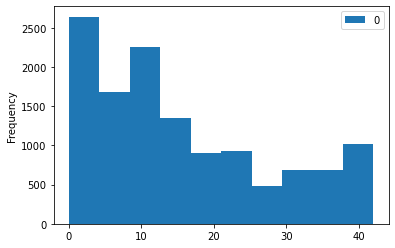

In [7]:
# Describe test Y data
df_y_test = pd.DataFrame(y_test)
print(df_y_test.describe())
df_y_test.plot.hist()

## Data Random Samples

In [ ]:
# Random signs from the Y data
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i in results[:10]:
    sign_index = y_train[i]
    print(i,sign_index,sign_names.at[sign_index,'SignName'])

In [ ]:
# Random signs images and the correspondent name
fig, axes = plt.subplots(5,5, figsize=(15,15))
results = list(np.random.permutation(np.arange(0,y_test.shape[0])))
for i,ax in  enumerate(axes.flat):
    pos = results[i]
    sign_index = y_train[pos]
    ax.set_title(sign_names.at[sign_index,'SignName'],fontsize=10)
    ax.imshow(X_train[pos])
    ax.set_axis_off()

## Data preprocessing

In [8]:
from sklearn.utils import shuffle
X_train = np.sum(X_train/3, axis=3, keepdims=True)[:100,]
X_valid = np.sum(X_valid/3, axis=3, keepdims=True)[:100,]
X_train, y_train = shuffle(X_train, y_train[:100])

In [9]:
import tensorflow as tf
from tensorflow.contrib.layers import flatten
def LeNet(x):
    mu = 0
    sigma = 0.1
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print(conv1.shape)
    # Flatten last convolution
    fc0   = flatten(conv1)
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1176, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 42), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(42))
    print(fc1.shape,fc2_W.shape,fc2_b.shape)
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    return logits

In [10]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 42)
rate = 0.001
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

(?, 14, 14, 6)
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.
(?, 120) (120, 42) (42,)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [11]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
BATCH_SIZE=128
EPOCHS=1
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [12]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)

    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

        validation_accuracy = evaluate(X_valid, y_valid[:100,])
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")


Training...



UnknownError: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node Conv2D (defined at /home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1748) ]]

Original stack trace for 'Conv2D':
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 149, in start
    self.asyncio_loop.run_forever()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2877, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2922, in _run_cell
    return runner(coro)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3146, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-d51a6cb1daab>", line 5, in <module>
    logits = LeNet(x)
  File "<ipython-input-9-d454f9698913>", line 8, in LeNet
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/ops/nn_ops.py", line 2010, in conv2d
    name=name)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/ops/gen_nn_ops.py", line 1071, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "/home/shurtado/.miniconda/envs/tensorflow-gpu/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
